<center><h1>NLP Capstone</h1></center>
<center><h2>Clustering/Classification of fiction from Project Gutenberg</h2></center>
<center><h2>Murali Mandayam</h2></center>
<center><h3>20th May 2019</h3></center>
<center><h3>www.thinkful.com</h3></center>
<br>
<h3>Objective:</h3><br>
In this capstone we attempt to cluster and classify old, fictional novels such as Huckleberry Finn, Tom Sawyer, Tale of Two Cities and others. The expectation is that our clustering and classification models will classify a text from any novel enabling us to identify the author.<br>
<br>
Here is our approach:<br>
1. Import all necessary modules for regular pandas, seaborn, NLP and others.<br>
2. Read the data from the <a href="https://www.gutenberg.org">Project Gutenberg</a> web site, and clean the data.<br>
3. Run the texts through spaCy to tokenize them.<br>
4. Add the lemma words<br>
5. Create the taggedDocument required for doc2vec<br>
6. Run KMeans and MeanShift models 
<br>
<br>
In this experiment each sentence from a novel is considered a document and labeled with the author's name.

<h2>Import all necessary modules</h2>

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

# Increase the dpi for better quality plots
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
import re

import warnings
# Suppressing annoying harmless error
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from warnings import simplefilter
warnings.simplefilter('ignore')
simplefilter(action='ignore', category=FutureWarning)

# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.cluster import KMeans

# Libraries for NLP classfication and test-train split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import tokenize
from nltk.tokenize import word_tokenize
set(stopwords.words('english'))

from sklearn.decomposition import PCA
from sklearn import metrics

# To expand words like "you've" to "you have"
# Make sure you install the 'contractions' module on your machine first with a 'pip install'
import contractions

# import time function
import time

<h3>Functions for cleaning input texts</h3>

In [34]:
# This is the utility function for standard text cleaning
# Removes any double dashes in the text such as '--'
# Removes any special characters such as left and right brackets ([]), and
# retains alpha-numeric text only
# Returns the first 900,000 words because of limited processing power in my local machine
#


def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--', ' ', text)
    text = re.sub("[\[].*?[\]]", " ", text)
    text = re.sub('\n', " ", text)
    return text


def read_till_end(filename):
    # Beyond the last chapter of the book there are some extra text about the author, publisher and other
    # information that are not related to the main story.
    # As these texts do not pertain to the main story we want to strip them off the text
    # All books have 'THE END' indicating end of the story, after which some additional text
    # appears about gutenberg organization

    f = open(filename, 'r')
    string = "THE END"
    return_string = ''
    finished = False
    for line in f:
        if not finished:
            if line.find(string) == -1:
                return_string += line
            else:
                finished = True
                return return_string


def strip_intro(text):
    # There is also some text at the very beginning of the book that are not related to the story. For example
    # licensing method, publisher's name etc. These should be stripped as well.

    content_pos = text.find('CONTENTS') + 10
    return text[content_pos:]


def clean_sp_chars(text):
    text = re.sub(r'’', "'", text)  # remove apostrophes
    text = re.sub('…', '', text)  # remove ellipses
    text = re.sub('♦', '', text)  # remove diamonds
    return text

Read the data from <a href="https://www.gutenberg.org">Project Gutenberg</a>, run the texts through the cleaning methods and store them in a string.<br>
<br>
Import the following 6 novels in .txt form (imported from https://www.gutenberg.org/browse/scores/top)<br>
1. Huckleberry Finn - Mark Twain<br>
2. Tom Sawyer - Mark Twain<br>
3. Ulysses - James Joyce<br>
4. Tale of Two Cities - Charles Dickens<br>
5. Jekyll & Hyde - R L Stevenson, and, <br>
6. Importance of being earnest - Oscal Wilde

In [35]:
# Intitlize the strings where book texts will be stored

h_finn = ""  # Huckleberry Finn
t_sawyer = ""  # Tom Sawyer
ulysses = ""  # Ulysses
t_cities = ""  # Tale of Two Cities
j_and_h = ""  # Jekyll and Hyde
oscar_w = ""  # Importance of being earnest - Oscar Wilde

# Read and strip unwanted text in Huckleberry Finn
filename = 't_sawyer_h_finn.txt'
h_finn = read_till_end(filename)
h_finn = strip_intro(h_finn)

# Read and strip unwanted text in Tom Sawyer
filename = 't_sawyer_twain.txt'
t_sawyer = read_till_end(filename)
t_sawyer = strip_intro(t_sawyer)

# Read and strip unwanted text in Ulysses
filename = 'j_joyce_ulysses.txt'
ulysses = read_till_end(filename)
ulysses = strip_intro(ulysses)

# Read and strip unwanted text in Tale of Two Cities
filename = 'c_dickens.txt'
t_cities = read_till_end(filename)
t_cities = strip_intro(t_cities)

# Read and strip unwanted text in J & H
filename = 'rl_stevenson.txt'
j_and_h = read_till_end(filename)
j_and_h = strip_intro(j_and_h)

# Read and strip unwanted text in Oscar Wilde novel
filename = 'oscar_wilde.txt'
oscar_w = read_till_end(filename)
oscar_w = strip_intro(oscar_w)

# Clean the data.
h_finn_clean = text_cleaner(h_finn)
t_sawyer_clean = text_cleaner(t_sawyer)
ulysses_clean = text_cleaner(ulysses)
t_cities_clean = text_cleaner(t_cities)
j_and_h_clean = text_cleaner(j_and_h)
oscar_w_clean = text_cleaner(oscar_w)

In [36]:
# Create a dataframe to keep the text from the novels
# We store each novel in a separate dataframe to preserve the author's name
df1 = pd.DataFrame(columns=['clean_text', 'author'])
df2 = pd.DataFrame(columns=['clean_text', 'author'])
df3 = pd.DataFrame(columns=['clean_text', 'author'])
df4 = pd.DataFrame(columns=['clean_text', 'author'])
df5 = pd.DataFrame(columns=['clean_text', 'author'])
df6 = pd.DataFrame(columns=['clean_text', 'author'])

In [37]:
# Populate the dataframe with the text and author's name

df1['clean_text'] = pd.Series(tokenize.sent_tokenize(h_finn_clean))
df1['author'] = 'Mark Twain'

df2['clean_text'] = pd.Series(tokenize.sent_tokenize(t_sawyer_clean))
df2['author'] = 'Mark Twain'

df3['clean_text'] = pd.Series(tokenize.sent_tokenize(ulysses_clean))
df3['author'] = 'James Joyce'

df4['clean_text'] = pd.Series(tokenize.sent_tokenize(t_cities_clean))
df4['author'] = 'Charles Dickens'

df5['clean_text'] = pd.Series(tokenize.sent_tokenize(j_and_h_clean))
df5['author'] = 'R L Stevenson'

df6['clean_text'] = pd.Series(tokenize.sent_tokenize(oscar_w_clean))
df6['author'] = 'Oscar Wilde'

# Concatenate all novel into one dataframe
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

In [38]:
# Update the word count in each novel
df['word_count'] = [len(_.split(' ')) for _ in df.clean_text]

In [39]:
# Expand the contractions in the text
df['clean_text'] = [contractions.fix(_) for _ in df['clean_text']]

In [40]:
df['clean_text'] = [_.lower() for _ in df['clean_text']]
df['clean_text'] = [clean_sp_chars(_) for _ in df['clean_text']]

In [41]:
_ = ' '.join(df.clean_text)
Counter(_.split(' ')).most_common(50)

[('the', 28415),
 ('and', 19961),
 ('of', 13343),
 ('a', 12875),
 ('to', 12149),
 ('i', 8667),
 ('in', 8475),
 ('', 8424),
 ('he', 7765),
 ('was', 6563),
 ('that', 6065),
 ('his', 6018),
 ('it', 5976),
 ('not', 4823),
 ('you', 4740),
 ('is', 4359),
 ('with', 4235),
 ('for', 3767),
 ('on', 3406),
 ('had', 3118),
 ('as', 3035),
 ('at', 2857),
 ('they', 2767),
 ('but', 2753),
 ('her', 2618),
 ('all', 2418),
 ('she', 2311),
 ('would', 2162),
 ('be', 2125),
 ('my', 2064),
 ('so', 2057),
 ('have', 2042),
 ('him', 2030),
 ('by', 2020),
 ('do', 1848),
 ('out', 1796),
 ('from', 1723),
 ('up', 1689),
 ('there', 1677),
 ('will', 1652),
 ('said', 1651),
 ('we', 1642),
 ('are', 1631),
 ('no', 1503),
 ('if', 1477),
 ('what', 1458),
 ('when', 1441),
 ('this', 1438),
 ('me', 1408),
 ('one', 1402)]

<h3>Tokenize the texts using spaCy</h3>

In [58]:
start = time.time()
nlp = spacy.load('en')
df['spacy_text'] = [nlp(_) for _ in df.clean_text]
print('Conversion done in {} minutes'.format((time.time() - start)/60))

Conversion done in 6.860159019629161 minutes


In [42]:
spacy_str = [str(x) for x in df['clean_text']]
spacy_str = str(spacy_str)
print(spacy_str[:200])

[' chapter i. civilizing huck.', 'miss watson.', 'tom sawyer waits.', 'chapter ii.', 'the boys escape jim.', "torn sawyer's gang.", 'deep-laid plans.', 'chapter iii.', 'a good going-over.', 'grace tri


In [60]:
start = time.time()
nlp = spacy.load('en')
spacy_text = nlp(spacy_str[:999999])
print('Conversion done in {} minutes'.format((time.time() - start)/60))

Conversion done in 1.039764368534088 minutes


In [61]:
# additional stop words identified visually:
sw = ['\n', "'s", '\n\n', 'q', 'x', 'let']
for _ in sw:
    nlp.vocab[_].is_stop = True

<h3>For word2vec doc2vec and other models, organize the parsed doc into lemmas, while filtering out punctuation
and stop words, and converting words to lower case lemmas.</h3>

In [62]:
df['lemmas'] = [[[
    token.lemma_.lower()
    for token in sent
    if not token.is_stop
    and not token.is_punct]
    for sent in doc.sents] for doc in df.spacy_text]

In [63]:
sentences = []
for sentence in spacy_text.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)

print(sentences[20])
print('We have {} sentences and {} tokens.'.format(len(sentences), len(spacy_text)))

['king', 'explain', 'loss']
We have 11224 sentences and 259617 tokens.


In [64]:
df['lemmas'] = [[[
    token.lemma_.lower()
    for token in sent
    if not token.is_stop
    and not token.is_punct]
    for sent in doc.sents] for doc in df.spacy_text]

In [65]:
df.head()

,clean_text,author,word_count,spacy_text,lemmas
0,chapter i. civilizing huck.,Mark Twain,5,"( , chapter, i., civilizing, huck, .)","[[ , chapter, i., civilize, huck]]"
1,miss watson.,Mark Twain,2,"(miss, watson, .)","[[miss, watson]]"
2,tom sawyer waits.,Mark Twain,3,"(tom, sawyer, waits, .)","[[tom, sawyer, wait]]"
3,chapter ii.,Mark Twain,2,"(chapter, ii, .)","[[chapter, ii]]"
4,the boys escape jim.,Mark Twain,4,"(the, boys, escape, jim, .)","[[boy, escape, jim]]"


In [67]:
# Lemma is a nested list. We need to take the words from the nested list and
# store them separately to train our model. Our model cannot take nested strings

df['lemma_words'] = [str(' '.join([str(' '.join(i))
                             for i in j if len(i) > 0])) for j in df.lemmas]

df['lemma_words'] = [j.split(' ') for j in df.lemma_words]

# Remove blank strings
df['lemma_words'] = [' '.join([i for i in j if len(i.strip()) > 0])
               for j in df.lemma_words]

In [135]:
df.head()

,clean_text,author,word_count,spacy_text,lemmas,lemma_words
0,chapter i. civilizing huck.,Mark Twain,5,"( , chapter, i., civilizing, huck, .)","[[ , chapter, i., civilize, huck]]",chapter i. civilize huck
1,miss watson.,Mark Twain,2,"(miss, watson, .)","[[miss, watson]]",miss watson
2,tom sawyer waits.,Mark Twain,3,"(tom, sawyer, waits, .)","[[tom, sawyer, wait]]",tom sawyer wait
3,chapter ii.,Mark Twain,2,"(chapter, ii, .)","[[chapter, ii]]",chapter ii
4,the boys escape jim.,Mark Twain,4,"(the, boys, escape, jim, .)","[[boy, escape, jim]]",boy escape jim


In [136]:
# Now that we have all the data cleaned up (hopefully cleaned up well) we will split it
# into training and testing so we can train the model first and then fit it on the test set

# Split the dataset to test and train. Retain 25% for test. Our label is the author of the novels
r = 4

# The dataset to be split is the lemmas column in our dataframe
X = df['lemma_words']
y = df['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=r)
X_train.shape

(27801,)

In [137]:
# First we have to create a TaggedDocument as Doc2Vec accepts only tagged data
from nltk.tokenize import word_tokenize
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[
                              str(i)]) for i, _d in enumerate(X_train)]

Create the model with hyper parameters.<br>
Creating the model may take a lot of time. Run it only once and save the model in a file.<br>
**_After the model is saved, comment out all code in the cell below so it doesn't get run inadvertently.
Run this cell for the first time OR when the training data changes._**

In [138]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha,
                min_alpha=0.00025,
                min_count=1,
                dm=1)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("Unit4_NLP_d2v.model")
print("Model Saved")

Model Saved


In [72]:
# Load our model
model = Doc2Vec.load("Unit4_NLP_d2v.model")

In [73]:
# Find the vectors for our data (df['lemma_words']) using Doc2Vec
lemma_vector = pd.DataFrame([model.docvecs[str(i)]
                             for i in range(len(tagged_data))])

Text(0.5, 1.0, 'Elbow curve')

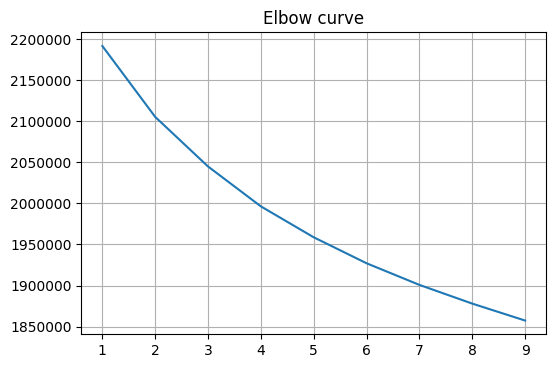

In [74]:
# Determine the optimal number of clusters using elbow curve plot

distorsions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(lemma_vector)
    distorsions.append(kmeans.inertia_)

plt.plot(K, distorsions)
plt.grid(True)
plt.title('Elbow curve')

<h3>The elbow curve above shows that optimal number of clusters is 3, because at 3 the curve has a small inflexion point.</h3>

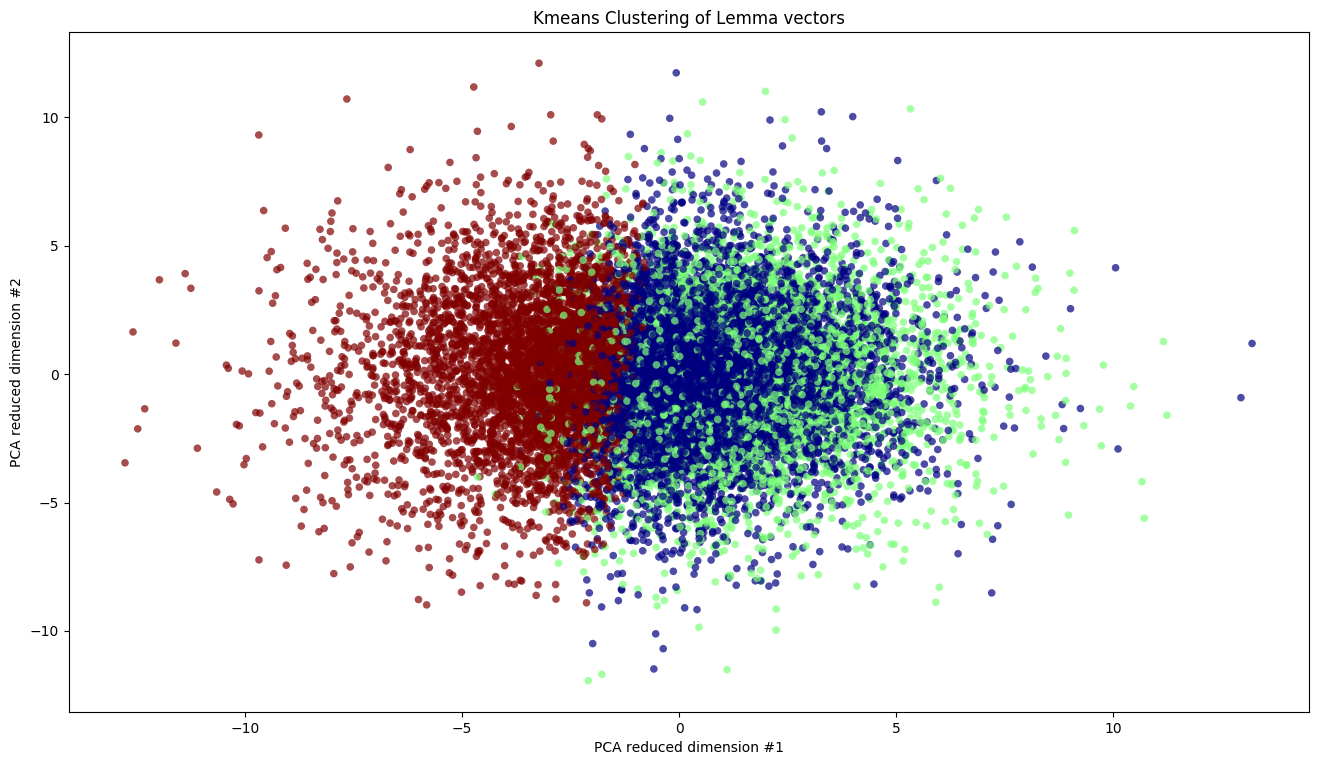

Silhouette: 0.13415756786869423
Frequency of unique values of the said array:
[[    0     1     2]
 [17484  5165  5152]]
Converged iterations are 32
Comparing k-means clusters against the data:
Time taken =  17.66 seconds


In [154]:
# Based on the elbow curve we can create PCA for 3 dimensions
# Though we have 6 authors let us try creating 3 clusters as our elbow curve says 3 is optimal
pca = PCA(n_components=3)

start = time.time()

distortions = []
# Calculate the distance from the center of the cluster to plot the elbow graph
kmeans = KMeans(n_clusters=3, tol=0.0000001, random_state=42).fit(lemma_vector)
distorsions.append(kmeans.inertia_)

# Fit our data with the model
X_pca = pca.fit_transform(lemma_vector)

# Get the cluster numbers for our dataset
y_pred = kmeans.fit_predict(X_pca)

# Plot the data. We used cmap=plt.cm.jet for colors
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap=plt.cm.jet,
            s=30, linewidths=0, alpha=0.7)
plt.xlabel('PCA reduced dimension #1')
plt.ylabel('PCA reduced dimension #2')
plt.title('Kmeans Clustering of Lemma vectors')
plt.show()

# Calculate the silhouette value
labels = kmeans.labels_
silhouette = metrics.silhouette_score(lemma_vector, labels, metric='euclidean')
print('Silhouette: {}'.format(silhouette))

unique_elements, counts_elements = np.unique(
    kmeans.labels_, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
print('Converged iterations are {}'.format(kmeans.n_iter_))

# Check the solution against the data.
print('Comparing k-means clusters against the data:')

print('Time taken = ', round(time.time()-start, 2), 'seconds')

Our Silhouette score is not good with the KMeans model. But not bad either. The classification of clusters looks pretty good looking at the frequency of the unique values.

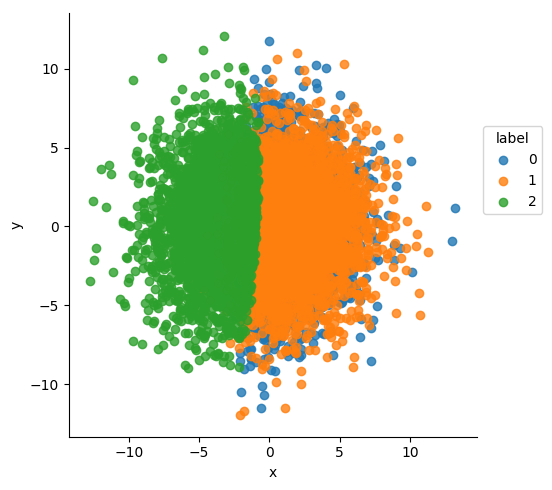

In [155]:
# Plot the clusters against the authors and see if they are classifed correctly
# Create a dataframe to keep plot parameters
df_for_plot = pd.DataFrame()
df_for_plot['x'] = X_pca[:, 0]
df_for_plot['y'] = X_pca[:, 1]
df_for_plot['clusters'] = kmeans.labels_

facet = sns.lmplot(data=df_for_plot, x='x', y='y', hue='clusters',
                   fit_reg=False, legend=False)

# add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                      title="label", fancybox=True)

In [77]:
# Try the MeanShift clustering on the PCA data

from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift.fit(X_pca)

# Extract cluster assignments for each data point.
labels = mean_shift.labels_

# Coordinates of the cluster centers.
cluster_centers = mean_shift.cluster_centers_

# Count our clusters.
n_clusters = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters))

# Get labels, number of clusters, similarity score
silhouette = metrics.silhouette_score(X_pca, labels, metric='euclidean')
print('K: {}, silhouette: {}'.format(n_clusters, silhouette))

Number of estimated clusters: 14
K: 14, silhouette: 0.3275268801913543


MeanShift categorizes into 14 clusters and with a better silhouette score than KMeans.

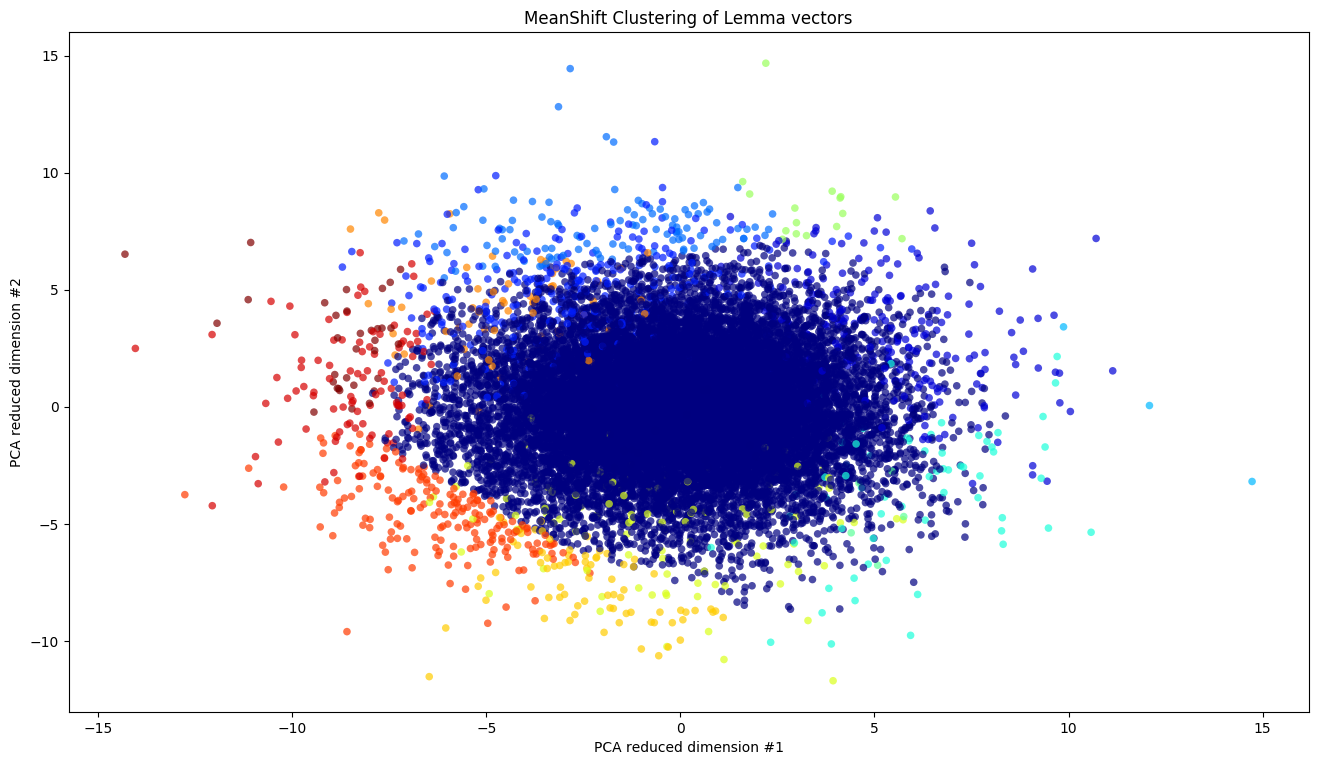

In [147]:
# Plot the MeanShift clusters
# Create a dataframe to keep plot parameters
df_for_plot = pd.DataFrame()
df_for_plot['x'] = X_pca[:, 0]
df_for_plot['y'] = X_pca[:, 1]
df_for_plot['clusters'] = labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=plt.cm.jet,
            s=30, linewidths=0, alpha=0.7)
plt.xlabel('PCA reduced dimension #1')
plt.ylabel('PCA reduced dimension #2')
plt.title('MeanShift Clustering of Lemma vectors')
plt.show()

In [156]:
df_for_plot.head()

,x,y,clusters
0,0.102169,-0.422381,1
1,1.779085,-4.034528,1
2,0.604779,-0.291900,0
3,0.816439,0.044504,0
4,-0.442315,-1.183525,1


In [157]:
# Use the df_for_plot data frame to store the data needed for wordcloud plotting

# Assiging X_train to a new column in df_for_plot was causing NaN values to be inserted
# The reset_index avoids NaNs by ignoring the original indices in X_train

X_train.reset_index(drop=True, inplace=True)

# Add X_train to df_for_plot for WordCloud plotting
df_for_plot = pd.concat([df_for_plot, X_train], axis=1)

# Add y to df_for_plot to add author name
df_for_plot['author'] = y_train.reset_index(drop=True)

In [175]:
unique_authors = df_for_plot.groupby(['clusters']).author.unique()
print(unique_authors[0])
print(unique_authors[1])
print(unique_authors[2])

['Oscar Wilde' 'James Joyce' 'Mark Twain' 'Charles Dickens'
 'R L Stevenson']
['James Joyce' 'Mark Twain' 'Charles Dickens' 'Oscar Wilde'
 'R L Stevenson']
['Mark Twain' 'James Joyce' 'Charles Dickens' 'Oscar Wilde'
 'R L Stevenson']


<h2>Generate WordCloud for X_train.</h2><br>
Even though the wordcloud plot could have been iterated through a for loop, I chose to plot them individually in 3 separate cells so they are displayed as separate images without the need to scroll to view the plots.

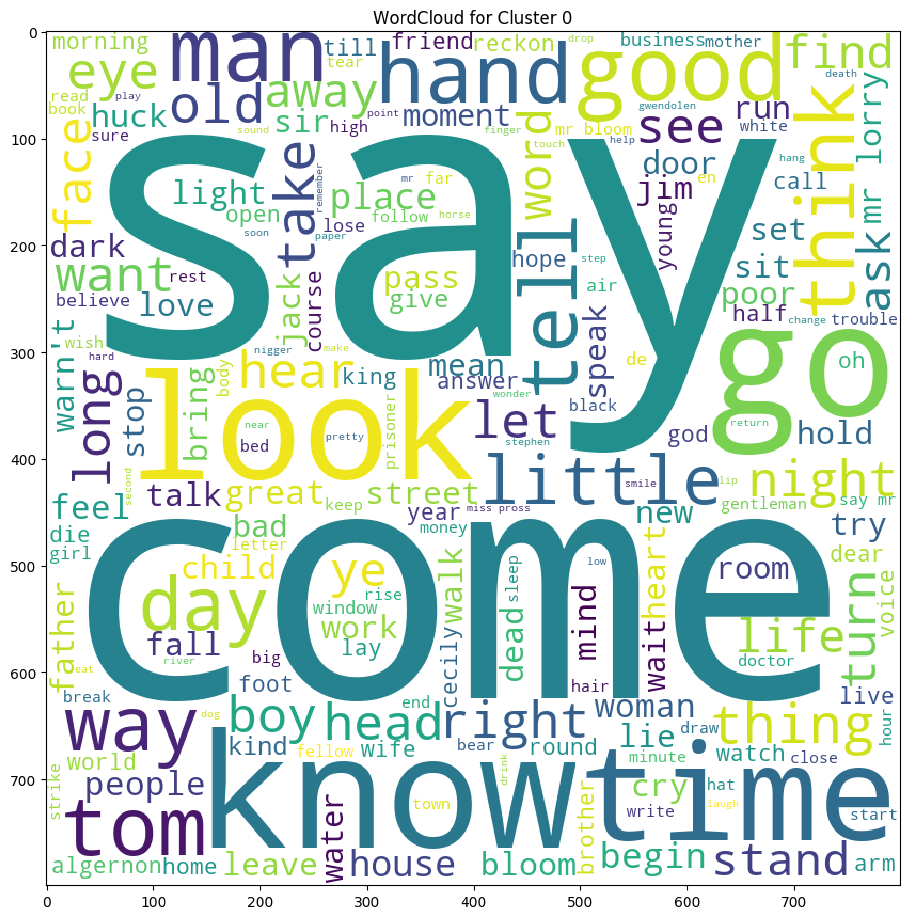

In [81]:
# Importing WordCloud module
from wordcloud import WordCloud, STOPWORDS

# iterate through the lemmas
lemmas = df_for_plot[df_for_plot['clusters'] == 0]['lemma_words']
lemma_words = ' '.join(lemmas)
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate(lemma_words)

# plot the WordCloud image
plt.rcParams["figure.figsize"] = [16, 9]
plt.title('WordCloud for Cluster 0')
plt.imshow(wordcloud)
plt.tight_layout(pad=0)

The data is being clustered around words in the novels though the expectation is that it would cluster based on author. Unfortunately none of the authors have a specific style of writing barring usage of a few words. We use the words in the cluster to plot a word cloud graph.

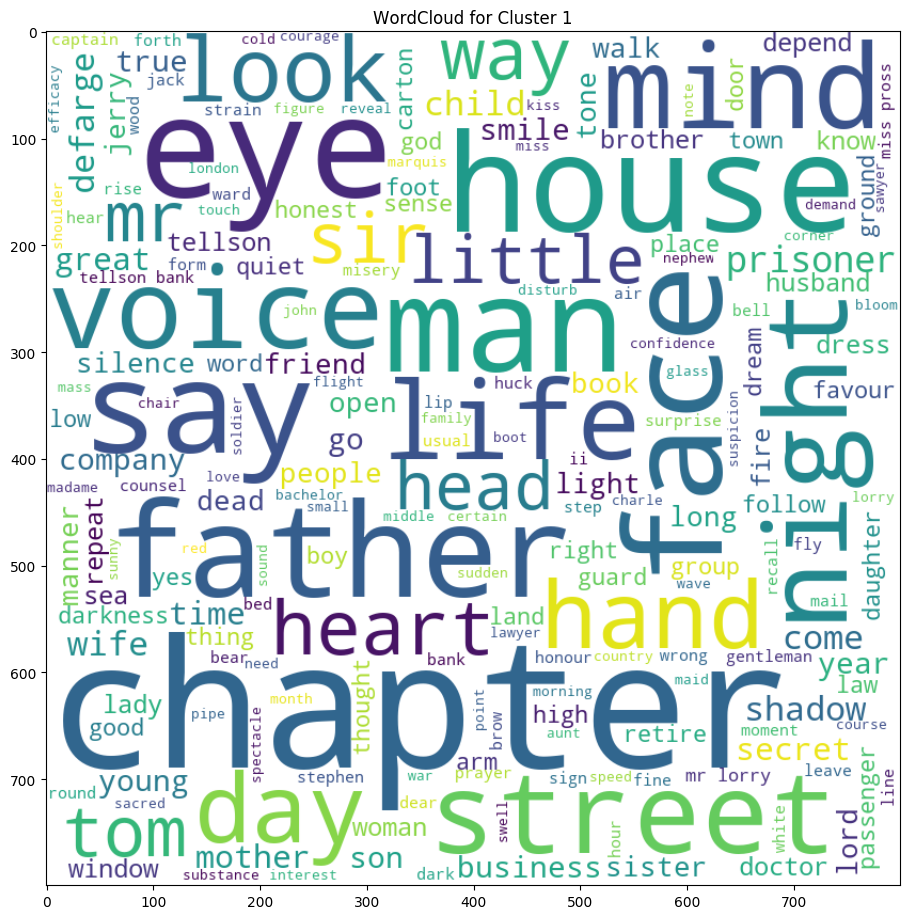

In [82]:
# WordCloud for Cluster #1

lemmas = df_for_plot[df_for_plot['clusters'] == 1]['lemma_words']
lemma_words = ' '.join(lemmas)
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate(lemma_words)

# plot the WordCloud image
plt.rcParams["figure.figsize"] = [16, 9]
plt.title('WordCloud for Cluster 1')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)

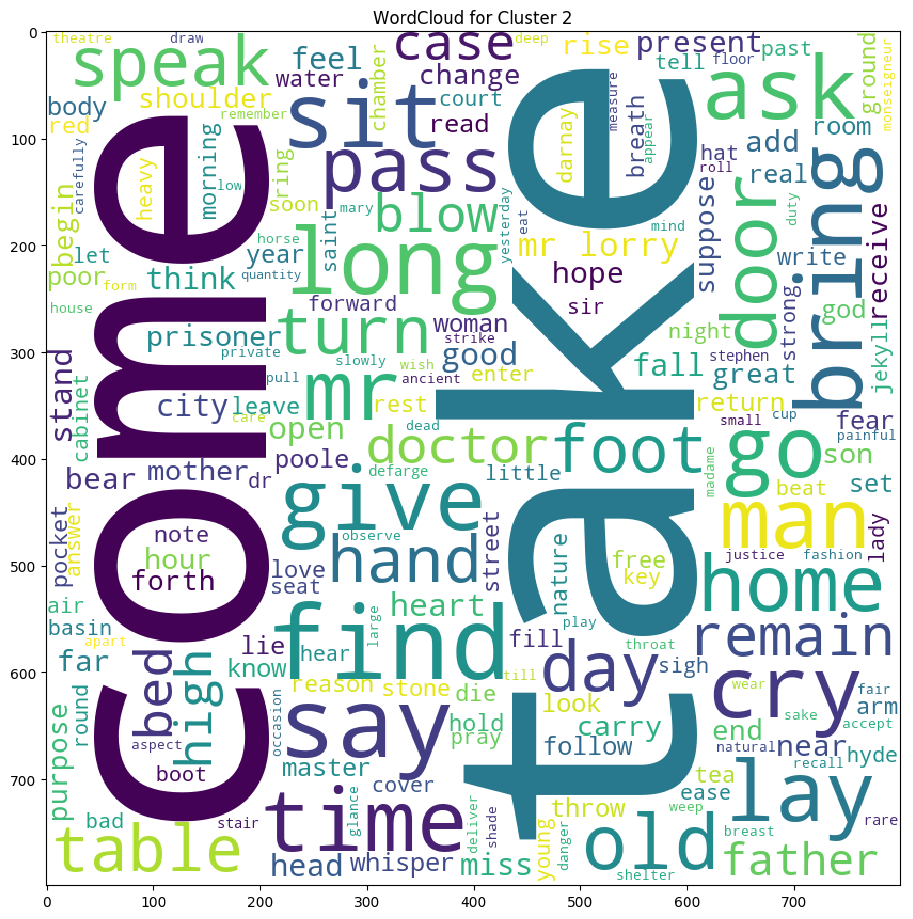

In [83]:
# WordCloud for Cluster #1

lemmas = df_for_plot[df_for_plot['clusters'] == 2]['lemma_words']
lemma_words = ' '.join(lemmas)
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate(lemma_words)

# plot the WordCloud image
plt.rcParams["figure.figsize"] = [16, 9]
plt.title('WordCloud for Cluster 2')
plt.imshow(wordcloud)
plt.tight_layout(pad=0)

In [84]:
y_train.reset_index(drop=True, inplace=True)

# Add y_train to df_for_plot for WordCloud plotting
df_for_plot = pd.concat([df_for_plot, y_train], axis=1)

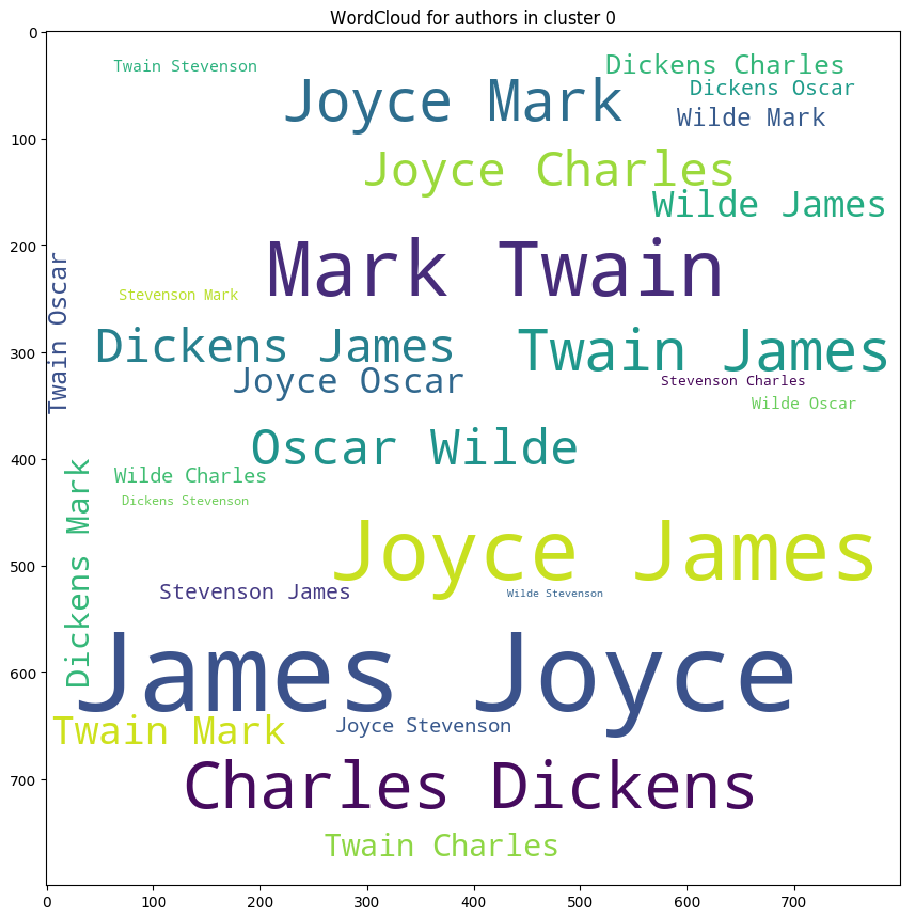

In [85]:
# WordCloud for Cluster #0

authors = df_for_plot[df_for_plot['clusters'] == 0]['author']
authors = ' '.join(authors)
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate(authors)

# plot the WordCloud image
plt.rcParams["figure.figsize"] = [16, 9]
plt.title('WordCloud for authors in cluster 0')
plt.imshow(wordcloud)
plt.tight_layout(pad=0)

Let us try and fit the X_test values and see how the clustering plays out.<br>
The similar_doc returns a tuple. The first value of he tuple is the index of the document to the training data, because our Unit4_NLP_d2v_model was created using training data (that was fed into taggedDocument).

In [86]:
# Now try fitting X_test on the model and see how the clusters play out

model = Doc2Vec.load("Unit4_NLP_d2v.model")

# Separate the words in X_test for infer_vector
X_test_1 = [x.split(' ') for x in X_test]

# to find the vector of a document which is not in training data
X_test_vector = [model.infer_vector(x) for x in X_test_1]

# To find most similar doc using tags
# most_similar returns the top 10 docs by default
# Set the topn variable to return more docs. For example topn=len(X_test) will return
# similarity for all X_test documents
similar_doc = model.docvecs.most_similar(X_test_vector)
print(similar_doc)

[('24551', 0.9772251844406128), ('19227', 0.9710699915885925), ('7144', 0.9680576324462891), ('8680', 0.9671904444694519), ('20653', 0.9665839672088623), ('8350', 0.9645915627479553), ('22236', 0.9638292789459229), ('426', 0.9636548161506653), ('1774', 0.9622317552566528), ('8649', 0.9612810015678406)]


Using the similar_doc values check the X_test document and the X_train documents to see if they have any similarity.

In [87]:
# Cross check the training data with labels from similar_doc
# limit it to to the first 5 labels in similar_doc

index = 0
for doc in X_test_1:
    # document here is basically the sentences in our novels
    print('For document {}'.format(index))
    print('\tmost_similar vector = ', similar_doc[index])
    print('\ttest document = ', X_test_1[index])
    print('\tauthor of test doc =', y_test.iloc[index])
    train_index = int(similar_doc[index][0])
    print('\ttraining doc =', X_train[train_index])
    print('\tauthor of taining doc = ', y_train[train_index])
    index += 1
    if index == 5:
        # stop after 5 documents
        break

For document 0
	most_similar vector =  ('24551', 0.9772251844406128)
	test document =  ['little', 'reck', 'feel', 'dull', 'ache', 'void', 'heart', 'pierce', 'core']
	author of test doc = James Joyce
	training doc = throb throb
	author of taining doc =  James Joyce
For document 1
	most_similar vector =  ('19227', 0.9710699915885925)
	test document =  ['uz', 'mos', 'de', 'head', 'er', 'de', 'islan', 'man', 'begin', 'come', 'aft', 'wid', 'de', 'lantern', "warn't", 'use', 'fer', 'wait', 'slide', 'overboard', 'en', 'strike', 'fer', 'de', 'islan']
	author of test doc = Mark Twain
	training doc = nosey flynn say
	author of taining doc =  James Joyce
For document 2
	most_similar vector =  ('7144', 0.9680576324462891)
	test document =  ['doctor', 'manette', 'take', 'give', 'eat', 'drink', 'work', 'day', 'dark', 'work', 'half', 'hour', 'mr', 'lorry', 'see', 'life', 'read', 'write']
	author of test doc = Charles Dickens
	training doc = lady bracknell
	author of taining doc =  Oscar Wilde
For docu

<h2>Using tf-idf and word2vec with TruncateSVD to check similarity.</h2>

In [92]:
# import PlaintextCorpusReader to convert our text as an NLTK corpus
# Note: The code below will work for English language text only

from nltk.corpus.reader.plaintext import PlaintextCorpusReader

# All our txt files are in the <pwd>/unit4_corpus folder where <pwd> is the current directory
# from where this notebook is launched. The text files can be found in the github folder

newcorpus = PlaintextCorpusReader('unit4_corpus/', '.*') # the '.*' is for reading all files in the folder

In [93]:
# From our new corpus create paragraphs
newcorpus_paras = []
for paragraph in newcorpus.paras():
    para = paragraph[0]
    # removing the double-dash from all words
    para = [re.sub(r'--', '', word) for word in para]
    # Forming each paragraph into a string and adding it to the list of strings.
    newcorpus_paras.append(' '.join(para))

print(newcorpus_paras[0:4])

['The Project Gutenberg EBook of A Tale of Two Cities , by Charles Dickens', 'This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever .', 'Title : A Tale of Two Cities A Story of the French Revolution', 'Author : Charles Dickens']


In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(
    newcorpus_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5,  # drop words that occur in more than half the paragraphs
                             min_df=2,  # only use words that appear at least twice
                             stop_words='english',
                             # convert everything to lower case
                             lowercase=True,
                             use_idf=True,  # we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2',  # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True  # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             )


# Applying the vectorizer
newcorpus_tfidf = vectorizer.fit_transform(newcorpus_paras)
print("Number of features: %d" % newcorpus_tfidf.get_shape()[1])

# splitting into training and test sets
X_train_tfidf, X_test_tfidf = train_test_split(
    newcorpus_tfidf, test_size=0.4, random_state=0)


# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0, n)]
# List of features
terms = vectorizer.get_feature_names()
# for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that
# the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 9430
Original sentence: — _Ex quibus_ , Stephen mumbled in a noncommittal accent , their two or four eyes conversing , _Christus_ or Bloom his name is or after all any other , _secundum carnem_ .
Tf_idf vector: {'stephen': 0.31222662474375334, 'conversing': 0.6417564754294058, 'bloom': 0.2771110068900226, 'accent': 0.5390824230643378, 'eyes': 0.35108801182756166}


In [96]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd = TruncatedSVD(50)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance*100)

Percent variance captured by all components: 18.777875575756234


In [98]:
# Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Component 0:
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Jack .    0.999907
Name: 0, dtype: float64
Component 1:
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Algernon .    0.999977
Name: 1, dtype: float64
Component 2:
— Yes , Mr Bloom said .                                                                                                                                                             0.886341
— Yes , Mr Bloom said .                                                                                                                                                             0.886341
Yes , her lips said more loudly , Mr Dollard .                                                                     

The component bucketing above seems to follow a pattern. For example, all words in Component 0 has the word Jack. In component 4 the common word seems to be 'Yes'.

In [102]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

test_variance_explained = svd.explained_variance_ratio_
test_total_variance = variance_explained.sum()
print("Percent variance captured by all components:", test_total_variance*100)

# Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:, i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 18.777875575756234
Component 0:
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Jack .    0.973394
Name: 0, dtype: float64
Component 1:
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Algernon .    0.973418
Name: 1, dtype: float64
Component 2:
— Yes , yes , Mr Bloom said after a dull sigh .              0.911797
— Yes , Mr Bloom said , teasing the curling catgut line .    0.902153
— Yes , Mr Bloom said .                                      0.901853
— Yes , Mr Bloom said .                                      0.901853
— Yes , Mr Bloom said .                                      0.901853
— Yes , Mr Bloom said .                                      0.901853
— O , yes

In [101]:
start = time.time()
h_finn_paras = re.split('\n', h_finn_clean)
t_sawyer_paras = re.split('\n', t_sawyer_clean)
t_cities_paras = re.split('\n', t_cities_clean)
oscar_w_paras = re.split('\n', oscar_w_clean)
j_and_h_paras = re.split('\n', j_and_h_clean)
ulysses_paras = re.split('\n', ulysses_clean)
clean_doc = ""
clean_doc = str(h_finn_paras + t_cities_paras + t_sawyer_paras +
                oscar_w_paras + j_and_h_paras + ulysses_paras)
clean_doc = clean_doc[:900000]
nlp = spacy.load('en')
nlp_doc = nlp(clean_doc)
print('Time to convert to nlp is = {} seconds'.format(time.time() - start))

Time to convert to nlp is = 46.64558410644531 seconds


In [110]:
sentences = []
for sentence in nlp_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)


print(sentences[20])
print('We have {} sentences and {} tokens.'.format(
    len(sentences), len(clean_doc)))

['thrash', 'around', ' ']
We have 15493 sentences and 900000 tokens.


In [104]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    sentences,
    # Number of threads to run in parallel (if your computer does parallel processing).
    workers=4,
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3,   # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)
print('done!')

done!


In [105]:
vocab = model.wv.vocab.keys()

# Print the vocab list that can be used to inout words and measure similarities
print(vocab)

dict_keys(['chapter', 'i.', 'huck', 'miss', 'watson', 'tom', 'sawyer', ' ', 'the', 'escape', 'jim', "'s", 'gang', 'deep', 'lay', 'plan', 'iii', 'a', 'good', 'grace', 'one', 'judge', 'father', '-pron-', 'go', 'thatcher', 'leave', 'lock', 'cabin', 'sink', 'body', 'rest', 'sleep', 'raise', 'dead', 'island', 'find', 'sign', 'cave', 'float', 'house', 'old', 'in', 'woman', 'slow', 'borrow', 'thing', 'board', 'wreck', 'hunt', 'boat', 'watchman', 'general', 'time', 'french', 'lose', 'raft', 'fog', 'white', 'lie', 'run', 'cairo', 'ashore', 'evening', 'call', 'wood', 'pile', 'tie', 'up', 'day', 'duke', 'work', 'camp', 'pirate', 'sword', 'loaf', 'town', 'lazy', 'boggs', 'sherburn', 'circus', 'ring', 'sell', 'royal', 'get', 'home', 'sick', 'take', 'passenger', 'family', 'be', 'sing', 'awful', 'square', 'funeral', 'bad', 'king', 'ask', 'hide', 'room', 'money', 'quick', 'small', 'england', 'mary', 'jane', 'line', 'explain', 'question', 'dig', 'row', 'powerful', 'story', 'sunday', 'like', 'stump', 'n

In [109]:
print(model.wv.most_similar(positive=['king', 'man'], negative=['woman']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print('\nThe words echo and smell are similar by ', round(
    model.wv.similarity('echo', 'william')*100, 2), '%')

# One of these things is not like the other...
print('\nThe word that does not match is: ', model.doesnt_match(
    "evening time thatcher passenger".split()))

[('duke', 0.9890068173408508), ('then', 0.9802711009979248), ('chair', 0.9789495468139648), ('word', 0.9772213697433472), ('open', 0.9737404584884644), ('lock', 0.9724452495574951), ('slowly', 0.9707854390144348), ('expect', 0.9692729115486145), ('got', 0.9669764637947083), ('bad', 0.9659359455108643)]

The words echo and smell are similar by  96.97 %

The word that does not match is:  thatcher


<h2>Conclusion</h2><br>

The results from our clustering exercise was not satisfactory. This could be because the `most_similar` method does well with large text corpus exceeding a 100s of millions of documents. Our X_test is a very small corpus of less than 7000 documents. Clearly we need to add more documents and see if the performance is better.

See these two stackoverflow articles about the efficiency of `most_similar`:<br>
https://stackoverflow.com/questions/49631758/gensim-doc2vec-most-similar-method-not-working-as-expected<br>
https://stackoverflow.com/questions/43051902/gensim-docvecs-most-similar-returns-ids-that-dont-exist<br>

While the results from KMeans and MeanShift clustering were somewhat encouraging we still need to train the model with a larger corpus for better results.<br>
<br>
However, the tf-idf and word2vec based modeling gives better results when looking for similarity. My test were limited by the corpus size and the fact that word2vec would not accept anything more than 999,999 tokens. My corpus has about two million tokens. 